# Case Study 3- Email Spam Classification



---


# Packages


In [18]:
# sys
import os
from os.path import isfile
from inspect import CO_VARARGS
import warnings

warnings.filterwarnings("ignore")  # ignoring warnings

# SKLearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFECV
from sklearn import metrics

#NLTK & NLP
import nltk
from urllib import request
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from string import punctuation
from nltk.stem import PorterStemmer


# Other Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from pandas_profiling import ProfileReport
from os import listdir, walk
from os.path import isfile, join
import re
import string
from itertools import groupby
import seaborn as sns
import email #library for managing email messages

<a name="DataPrepAndEDA"></a>
# Data Preparation and EDA

### Helper functions

In [3]:
# to count letters and punctuation in a string
count = lambda l1, l2: sum([1 for x in l1 if x in l2])


def replace_multiple(mainString, toBeReplaces, newString):
    """
    Replace a set of multiple sub strings with a new string in main string.
    """
    # Iterate over the strings to be replaced
    for elem in toBeReplaces:
        # Check if string is in the main string
        if elem in mainString:
            # Replace the string
            mainString = mainString.replace(elem, newString)

    return mainString


def grid_search(X, y, model, grid, score, cv):
    # define search
    search_grid_search_measure = GridSearchCV(
        model, grid, scoring=score, cv=cv, n_jobs=nj, verbose=1
    )

    labels_true = y.to_numpy()
    labels_true = np.squeeze(np.asarray(np.transpose(labels_true)))

    # perform the search
    results_grid_search_measure = search_grid_search_measure.fit(X, labels_true)

    return results_grid_search_measure



### Setting global variables

In [5]:
##### TEST with 3 varying sizes of data: small, medium, all 

directory = "/Users/sophiawu/QTW/case study 3/Data"

sub_dirs = [x[0] for x in os.walk(directory) if x[0] != directory]

results_df = pd.DataFrame()

# setting n_jobs
nj = -1

### Parsing email files

In [6]:
%%time
for d in sub_dirs:
    files = [f for f in os.listdir(d) if os.path.isfile(os.path.join(d, f))]

    try:
        files.remove(".DS_Store")
        files.remove("Zone.Identifier")
    except:
        pass

    for file in files:
        # storing empty email body messages
        email_body_temp = []

        with open(f"{d}/{file}", encoding="latin1") as f:
            lines = f.readlines()

        in_reply_cnt = 0  # is there a reply thread
        sub_line_all_caps = 0  # is subject line all caps
        sub_line_punctuation = 0  # does subject line have punctuation
        sub_line_punctuation_cnt = 0  # count punctuation chars in subject line
        sub_line_repeat_punct = 0  # does subject line have repeat punctuation
        sub_line_repeat_punct_cnt = 0  # count repeat punctuation chars in subject line
        is_multipart = 0  # is multi-part
        cap_words_sub_line_cnt = 0  # count of cap words in subject line
        capital_run_length_total_s_line = 0  # total length of cap words in subject line
        capital_run_length_average_s_line = (
            0  # average length of cap word in subject line
        )
        capital_run_length_longest_s_line = (
            0  # longest length of cap word in subject line
        )
        digits_in_sub_line = 0  # are there digits in the subject line
        n_lines = len(lines)  # number of lines in the whole file
        blank_lines = 0  # number of blank lines in the whole file

        for line in lines:
            if "Subject: " in line:
                s_line = line.strip().replace("Subject: ", "")

                if re.search(r"subject:.* re:", line.lower()):
                    in_reply_cnt = 1
                    s_line = replace_multiple(s_line, ["Re: ", "RE: ",], "")

                # remove special characters and white space
                s_line_string = "".join(e for e in s_line if e.isalnum())

                # subject line contains digits
                if re.search(r"\d", s_line_string):
                    digits_in_sub_line = 1

                    # remove digits to check if all upper
                    s_line_string = re.sub(r"\d", "", s_line_string)

                num_upper = sum(1 for c in s_line_string if c.isupper())
                ttl_chars = len(s_line_string)

                # check if all upper
                if num_upper == ttl_chars:
                    sub_line_all_caps = 1

                # find the number of cap words in the subject line
                cap_words_sub_line = re.findall(r"(?!RE:)\b[A-Z]{1,}\b", s_line)
                cap_words_sub_line_cnt = len(cap_words_sub_line)

                # capital word lengths in subject line
                if cap_words_sub_line_cnt:
                    cap_word_lengths = [len(word) for word in cap_words_sub_line]

                    # the total length capital words in subject line
                    capital_run_length_total_s_line = sum(cap_word_lengths)

                    # the average length capital word in subject line
                    capital_run_length_average_s_line = (
                        capital_run_length_total_s_line / len(cap_words_sub_line)
                        if len(cap_words_sub_line)
                        else 0
                    )

                    # the longest all capital word in the subject line
                    capital_run_length_longest_s_line = (
                        max(cap_word_lengths) if cap_word_lengths else 0
                    )

                # punctation count and repeats in subject line
                if any(char in string.punctuation for char in line if char != ":"):
                    # does subject line contain any punctuation
                    sub_line_punctuation = 1

                    # total count of punctuation in subject line
                    sub_line_punctuation_cnt = count(s_line, set(string.punctuation))

                    # are punctuation chars repeated consecutively in subject line
                    consecutive_repeats = groupby(s_line)
                    punct_consecutive = [
                        (label, sum(1 for _ in group))
                        for label, group in consecutive_repeats
                        if label in string.punctuation
                    ]

                    # identify consecutive repeating punctuation chars in subject line
                    for punct in punct_consecutive:
                        if punct[1] > 1:
                            sub_line_repeat_punct = 1

                            # total consecutively repeated punctuation chars in subject line
                            sub_line_repeat_punct_cnt += punct[1]

            if "content-type: multipart" in line.lower():
                is_multipart = 1

            if line == "\n":
                blank_lines += 1

            # append all lines into email_body
            email_body_temp.append(line)
            # once appended convert from list to string form
            email_body = ''.join(email_body_temp)
            # using email library to extract the email body
            b = email.message_from_string(email_body)
            body = ""
            # cleans email body and filters through non-"email body" type content
            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))

                    # skip any text/plain (txt) attachments
                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True)  # decode
                        break
            # not multipart - i.e. plain text, no attachments, keeping fingers crossed
            else:
                body = b.get_payload(decode=True)
          ############## "email_body" content END ##############

        temp_df = pd.DataFrame(
            {
                "filename": file,
                "email_body": body,
                "contains_reply": in_reply_cnt,
                "is_multipart": is_multipart,
                "sub_line_all_caps": sub_line_all_caps,
                "sub_line_punctuation": sub_line_punctuation,
                "sub_line_punctuation_cnt": sub_line_punctuation_cnt,
                "sub_line_repeat_punct": sub_line_repeat_punct,
                "sub_line_repeat_punct_cnt": sub_line_repeat_punct_cnt,
                "sub_line_cap_words_cnt": cap_words_sub_line_cnt,
                "sub_line_cap_length_total": capital_run_length_total_s_line,
                "sub_line_cap_length_average": capital_run_length_average_s_line,
                "sub_line_cap_length_longest": capital_run_length_longest_s_line,
                "digits_in_sub_line": digits_in_sub_line,
                "body_lines": n_lines - blank_lines,
                "blank_lines": blank_lines,
                "is_spam": [1 if "spam" in d else 0],
            },
            index=[0],
        )

        results_df = results_df.append(temp_df, ignore_index=True)
        

# source: from QTW lecture 5

CPU times: user 9min 33s, sys: 10.1 s, total: 9min 43s
Wall time: 11min 56s


In [7]:
results_df.head()

,filename,email_body,contains_reply,is_multipart,sub_line_all_caps,sub_line_punctuation,sub_line_punctuation_cnt,sub_line_repeat_punct,sub_line_repeat_punct_cnt,sub_line_cap_words_cnt,sub_line_cap_length_total,sub_line_cap_length_average,sub_line_cap_length_longest,digits_in_sub_line,body_lines,blank_lines,is_spam
0,00249.5f45607c1bffe89f60ba1ec9f878039a,"b'Dear Homeowner,\n \nInterest Rates are at th...",0,0,0,0,0,0,0,1,4,4.000000,4,0,42,16,1
1,0355.94ebf637e4bd3db8a81c8ce68ecf681d,"b""Friend,Now you can copy DVD's and Games\nhtt...",0,1,0,1,7,1,6,2,6,3.000000,3,0,147,36,1
2,0395.bb934e8b4c39d5eab38f828a26f760b4,"b"" Pocket the newest 8 year annuity!\t Pocket ...",0,1,0,1,1,0,0,0,0,0.000000,0,1,260,12,1
3,0485.9021367278833179285091e5201f5854,b'<html><head>\n<title>Congratulations! You Ge...,0,0,0,1,2,0,0,0,0,0.000000,0,0,95,20,1
4,00373.ebe8670ac56b04125c25100a36ab0510,b'ATTENTION: This is a MUST for ALL Computer U...,0,0,1,0,0,0,0,6,37,6.166667,11,0,50,15,1


<a name="EDA"></a>
### EDA

Let's start by getting a list of columns (before NLP):

In [8]:
results_df.columns

Index(['filename', 'email_body', 'contains_reply', 'is_multipart',
       'sub_line_all_caps', 'sub_line_punctuation', 'sub_line_punctuation_cnt',
       'sub_line_repeat_punct', 'sub_line_repeat_punct_cnt',
       'sub_line_cap_words_cnt', 'sub_line_cap_length_total',
       'sub_line_cap_length_average', 'sub_line_cap_length_longest',
       'digits_in_sub_line', 'body_lines', 'blank_lines', 'is_spam'],
      dtype='object')

In [9]:
results_df.describe()

,contains_reply,is_multipart,sub_line_all_caps,sub_line_punctuation,sub_line_punctuation_cnt,sub_line_repeat_punct,sub_line_repeat_punct_cnt,sub_line_cap_words_cnt,sub_line_cap_length_total,sub_line_cap_length_average,sub_line_cap_length_longest,digits_in_sub_line,body_lines,blank_lines,is_spam
count,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000
mean,0.392067,0.080616,0.024912,0.710788,2.580455,0.113974,0.590720,0.604512,2.259168,1.166761,1.344595,0.232225,103.692184,15.289319,0.256495
std,0.488224,0.272252,0.155860,0.453409,19.765051,0.317788,13.612726,1.581370,6.374567,1.884834,2.294267,0.422263,176.614053,31.644103,0.436710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,6.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.000000,9.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,3.000000,2.500000,3.000000,0.000000,98.000000,14.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1884.000000,1.000000,1290.000000,104.000000,354.000000,12.000000,14.000000,1.000000,6310.000000,756.000000,1.000000


In [10]:
results_df['is_spam'].value_counts(normalize=False)

0    13908
1     4798
Name: is_spam, dtype: int64

In [11]:
results_df['is_spam'].value_counts(normalize=True)

0    0.743505
1    0.256495
Name: is_spam, dtype: float64

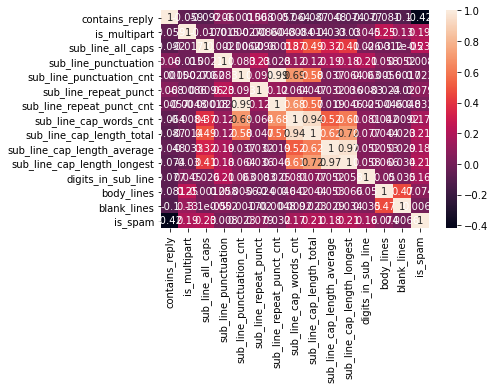

In [12]:
corrMatrix = results_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

<a name="Missing"></a>
### Missing Data
No fields have missing data:

In [13]:
results_df.isnull().sum()

filename                       0
email_body                     0
contains_reply                 0
is_multipart                   0
sub_line_all_caps              0
sub_line_punctuation           0
sub_line_punctuation_cnt       0
sub_line_repeat_punct          0
sub_line_repeat_punct_cnt      0
sub_line_cap_words_cnt         0
sub_line_cap_length_total      0
sub_line_cap_length_average    0
sub_line_cap_length_longest    0
digits_in_sub_line             0
body_lines                     0
blank_lines                    0
is_spam                        0
dtype: int64